In [1]:
import os

directory = "./assets"

if not directory:
    directory = input("Input raw dataset directory:")

files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

count = 1
if files:
    curr = files[0].split("_")[0]
else:
    print("No files found in the directory.")
    exit()

for file in files:
    file_split = file.split("_")
    if file_split[0] != curr:
        curr = file_split[0]
        count += 1
    
    new_file_name = "_".join(file_split[1:])
    new_file_name = str(count).zfill(3) + "_" + new_file_name
    
    old_path = os.path.join(directory, file)
    new_path = os.path.join(directory, new_file_name)
    
    os.rename(old_path, new_path)
    print(f"Successfully changed file name from ({file}) to ({new_file_name})")

Successfully changed file name from (001_3_1.tif) to (001_3_1.tif)
Successfully changed file name from (001_3_2.tif) to (001_3_2.tif)
Successfully changed file name from (001_3_3.tif) to (001_3_3.tif)
Successfully changed file name from (001_3_4.tif) to (001_3_4.tif)
Successfully changed file name from (001_3_5.tif) to (001_3_5.tif)
Successfully changed file name from (001_3_6.tif) to (001_3_6.tif)
Successfully changed file name from (001_3_7.tif) to (001_3_7.tif)
Successfully changed file name from (001_3_8.tif) to (001_3_8.tif)
Successfully changed file name from (001_4_1.tif) to (001_4_1.tif)
Successfully changed file name from (001_4_2.tif) to (001_4_2.tif)
Successfully changed file name from (001_4_3.tif) to (001_4_3.tif)
Successfully changed file name from (001_4_4.tif) to (001_4_4.tif)
Successfully changed file name from (001_4_5.tif) to (001_4_5.tif)
Successfully changed file name from (001_4_6.tif) to (001_4_6.tif)
Successfully changed file name from (001_4_7.tif) to (001_4_7.

In [2]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def skeletonize(img):
    """Alternative skeletonization implementation without ximgproc"""
    skel = np.zeros(img.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    while True:
        open_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(img, open_img)
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skel

def process_fingerprint(image_path, output_path, target_size=None, upscale_factor=1.0):
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Resize if needed
    if target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LANCZOS4)
    elif upscale_factor != 1.0:
        h, w = image.shape
        image = cv2.resize(image, (int(w*upscale_factor), int(h*upscale_factor)), 
                         interpolation=cv2.INTER_LANCZOS4)
    
    # 1. Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
    
    # 2. Noise reduction
    denoised = cv2.bilateralFilter(enhanced, 9, 75, 75)
    
    # 3. Adaptive thresholding
    thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 21, 7)
    
    # 4. Morphological operations
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # 5. Skeletonization (using alternative method)
    skeleton = skeletonize(morph)
    
    # 6. Final inversion and saving
    result = cv2.bitwise_not(skeleton)
    cv2.imwrite(output_path, result)

def batch_process_fingerprints(input_folder, output_folder, upscale=False):
    """
    Process all fingerprints in a folder
    """
    os.makedirs(output_folder, exist_ok=True)
    files = [f for f in os.listdir(input_folder) if f.lower().endswith('.tif')]
    
    for filename in tqdm(files, desc="Processing Fingerprints"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        
        try:
            if upscale:
                process_fingerprint(input_path, output_path, upscale_factor=2.0)
            else:
                process_fingerprint(input_path, output_path)
        except Exception as e:
            print(f"\nError processing {filename}: {str(e)}")
            continue

if __name__ == "__main__":
    INPUT_FOLDER = "assets"
    OUTPUT_FOLDER = "processed"
    UPSCALE_IMAGES = True  # Set to True for 2x upscaling
    
    print("Starting fingerprint processing...")
    batch_process_fingerprints(INPUT_FOLDER, OUTPUT_FOLDER, upscale=UPSCALE_IMAGES)
    print("\nProcessing completed successfully!")

Starting fingerprint processing...


Processing Fingerprints: 100%|██████████| 928/928 [00:30<00:00, 30.12it/s]


Processing completed successfully!


In [3]:
import os
import shutil
import random
from tqdm import tqdm

# Set random seed for reproducibility
random.seed(42)  # Ensures the same split every time you run the code

# Define paths
dataset_folder = "processed"
train_folder = "dataset/train"
test_folder = "dataset/test"

# Create train and test folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get all image files and shuffle them
all_files = [f for f in os.listdir(dataset_folder) if f.endswith('.tif')]
random.shuffle(all_files)  # Shuffle to ensure random distribution

# Calculate split index (80% train, 20% test)
split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]  # First 80% for training
test_files = all_files[split_idx:]   # Remaining 20% for testing

print(f"Found {len(all_files)} total fingerprint images")
print(f"- Training images: {len(train_files)} (80%)")
print(f"- Test images: {len(test_files)} (20%)")

# Function to copy files
def copy_files(file_list, destination_folder):
    for file in tqdm(file_list, desc=f"Copying to {os.path.basename(destination_folder)}"):
        src = os.path.join(dataset_folder, file)
        dest = os.path.join(destination_folder, file)
        shutil.copy2(src, dest)

# Copy files to respective folders
copy_files(train_files, train_folder)
copy_files(test_files, test_folder)

print("\nDataset organization completed:")
print(f"- Training set: {len(train_files)} images (copied to {train_folder})")
print(f"- Test set: {len(test_files)} images (copied to {test_folder})")
print(f"Original files remain intact in {dataset_folder}")

Found 928 total fingerprint images
- Training images: 742 (80%)
- Test images: 186 (20%)


Copying to test: 100%|██████████| 186/186 [00:00<00:00, 664.64it/s]


Dataset organization completed:
- Training set: 742 images (copied to dataset/train)
- Test set: 186 images (copied to dataset/test)
Original files remain intact in processed


In [4]:
import cv2
import numpy as np
import os
import random
from tqdm import tqdm

# Path configuration
test_dir = os.path.join("dataset", "test")

def apply_block_damage_smart(image, block_size=80, num_blocks=7):
    """Apply white block damage only on fingerprint area."""
    damaged = np.copy(image)
    height, width = image.shape
    mask = image < 250
    ys, xs = np.where(mask)

    if len(xs) == 0:
        return damaged

    for _ in range(num_blocks):
        idx = random.randint(0, len(xs) - 1)
        x_center, y_center = xs[idx], ys[idx]
        x1 = max(0, x_center - block_size // 2)
        y1 = max(0, y_center - block_size // 2)
        x2 = min(width, x1 + block_size)
        y2 = min(height, y1 + block_size)
        damaged[y1:y2, x1:x2] = 255
    return damaged

def apply_blur_damage(image, block_size=60, num_blocks=5):
    damaged = np.copy(image)
    height, width = image.shape

    for _ in range(num_blocks):
        x = random.randint(0, width - block_size)
        y = random.randint(0, height - block_size)
        roi = damaged[y:y+block_size, x:x+block_size]
        blurred = cv2.GaussianBlur(roi, (11, 11), 0)
        damaged[y:y+block_size, x:x+block_size] = blurred
    return damaged

def apply_elliptical_noise(image, num_ellipses=5):
    damaged = np.copy(image)
    height, width = image.shape

    for _ in range(num_ellipses):
        center = (
            random.randint(0, width),
            random.randint(0, height)
        )
        axes = (
            random.randint(20, 60),
            random.randint(10, 30)
        )
        angle = random.randint(0, 180)
        cv2.ellipse(damaged, center, axes, angle, 0, 360, 255, -1)
    return damaged

def apply_combined_damage(image):
    """Apply all three types of damage sequentially."""
    image = apply_block_damage_smart(image)
    image = apply_blur_damage(image)
    image = apply_elliptical_noise(image)
    return image

# Get all test images (.tif files)
test_images = [f for f in os.listdir(test_dir) if f.endswith(".tif")]
print(f"Found {len(test_images)} test images to process")

# Process and overwrite originals
for filename in tqdm(test_images, desc="Applying combined damage"):
    image_path = os.path.join(test_dir, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        damaged_image = apply_combined_damage(image)
        cv2.imwrite(image_path, damaged_image)

print(f"\nOverwritten {len(test_images)} images with combined damage in {test_dir}")


Found 186 test images to process


Applying combined damage: 100%|██████████| 186/186 [00:03<00:00, 54.08it/s]


Overwritten 186 images with combined damage in dataset\test


TEST NEW APPROACH

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Paths
train_dir = "dataset/train"
test_dir = "dataset/test"
batch_size = 8
img_size = (224, 224)  # Resize images

# Get all .tif images
image_files = [f for f in os.listdir(train_dir) if f.endswith(".tif")]

# Extract class labels from filenames (e.g., "001_1.tif" → class 001 → index 0)
class_labels = sorted(set(f.split("_")[0] for f in image_files))  # Unique classes
class_to_index = {label: i for i, label in enumerate(class_labels)}

# Function to load and preprocess images
def load_image(filename, dir_path, class_to_index):
    img_path = os.path.join(dir_path, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # still loading in grayscale
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)           # (224, 224, 1)
    img = np.repeat(img, 3, axis=-1)             # (224, 224, 3) → RGB from grayscale

    class_id = filename.split("_")[0]
    label = class_to_index[class_id]

    return img, label

# Load all images into memory
dataset = [load_image(f, train_dir, class_to_index) for f in image_files]

# Convert to TensorFlow dataset
X, y = zip(*dataset)  # Split images and labels
X = np.array(X, dtype=np.float32)  # Convert to NumPy array
y = np.array(y, dtype=np.int32)

# Create tf.data.Dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((X, y))
tf_dataset = tf_dataset.batch(batch_size).shuffle(len(y))

print(f"✅ Loaded {len(y)} images into a TensorFlow dataset!")

✅ Loaded 742 images into a TensorFlow dataset!


In [6]:
train_files = [f for f in os.listdir(train_dir) if f.endswith(".tif")]
train_labels = sorted(set(f.split("_")[0] for f in train_files))
class_to_index = {label: i for i, label in enumerate(train_labels)}

# Load training data
train_data = [load_image(f, train_dir, class_to_index) for f in train_files]
X_train, y_train = zip(*train_data)
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)

# Convert to tf.data.Dataset and batch it
tf_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_dataset = tf_dataset.shuffle(len(y_train)).batch(batch_size)

print(f"✅ Loaded {len(y_train)} training images into TensorFlow dataset")


✅ Loaded 742 training images into TensorFlow dataset


In [7]:
test_image_files = [f for f in os.listdir(test_dir) if f.endswith(".tif")]

# Function to load and preprocess test images
test_dataset = [load_image(f, test_dir, class_to_index) for f in test_image_files]

# Convert to TensorFlow test dataset
X_test, y_test = zip(*test_dataset)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

# Create tf.data.Dataset for testing
tf_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
tf_test_dataset = tf_test_dataset.batch(batch_size)
print(f"✅ Loaded {len(y_test)} training images into TensorFlow dataset")

✅ Loaded 186 training images into TensorFlow dataset


In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment(image, label):
    return data_augmentation(image), label

# Apply augmentation before batching
tf_dataset = tf_dataset.map(augment)

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D

# Number of classes (adjust dynamically)
num_classes = 80  # Since your classes range from 001 to 080

# Input shape (grayscale images need 3 channels for VGG16)
input_shape = (224, 224, 3)

# Load VGG16 with pre-trained weights (exclude top layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze the base model (VGG16) to retain pre-trained weights
base_model.trainable = False  

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)  # Flatten features
x = Dense(512, activation="relu")(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Regularization
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)  # Classification layer

# Define model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Re-compile with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
)

In [11]:
model.fit(tf_dataset,
          validation_data=tf_test_dataset,
          epochs=30,
          callbacks=[lr_scheduler])

Epoch 1/30
93/93 [==============================] - 34s 206ms/step - loss: 4.0661 - accuracy: 0.0714 - val_loss: 3.3366 - val_accuracy: 0.0591 - lr: 1.0000e-05
Epoch 2/30
93/93 [==============================] - 16s 167ms/step - loss: 3.4589 - accuracy: 0.1226 - val_loss: 2.7736 - val_accuracy: 0.1290 - lr: 1.0000e-05
Epoch 3/30
93/93 [==============================] - 15s 158ms/step - loss: 3.1623 - accuracy: 0.1415 - val_loss: 2.5013 - val_accuracy: 0.3011 - lr: 1.0000e-05
Epoch 4/30
93/93 [==============================] - 16s 168ms/step - loss: 2.9653 - accuracy: 0.1604 - val_loss: 2.2382 - val_accuracy: 0.3925 - lr: 1.0000e-05
Epoch 5/30
93/93 [==============================] - 15s 160ms/step - loss: 2.8617 - accuracy: 0.1900 - val_loss: 1.9507 - val_accuracy: 0.3925 - lr: 1.0000e-05
Epoch 6/30
93/93 [==============================] - 15s 162ms/step - loss: 2.7458 - accuracy: 0.1941 - val_loss: 1.8587 - val_accuracy: 0.4409 - lr: 1.0000e-05
Epoch 7/30
93/93 [======================

In [12]:
model.fit(tf_dataset,
          validation_data=tf_test_dataset,
          epochs=15,
          callbacks=[lr_scheduler])

Epoch 1/15
93/93 [==============================] - 15s 163ms/step - loss: 1.7255 - accuracy: 0.4528 - val_loss: 0.4172 - val_accuracy: 0.8280 - lr: 1.0000e-05
Epoch 2/15
93/93 [==============================] - 15s 158ms/step - loss: 1.6238 - accuracy: 0.4865 - val_loss: 0.4028 - val_accuracy: 0.8710 - lr: 1.0000e-05
Epoch 3/15
93/93 [==============================] - 15s 165ms/step - loss: 1.7372 - accuracy: 0.4461 - val_loss: 0.4674 - val_accuracy: 0.8333 - lr: 1.0000e-05
Epoch 4/15
93/93 [==============================] - 15s 159ms/step - loss: 1.6954 - accuracy: 0.4677 - val_loss: 0.3851 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 5/15
93/93 [==============================] - 15s 159ms/step - loss: 1.6317 - accuracy: 0.4933 - val_loss: 0.4401 - val_accuracy: 0.8280 - lr: 1.0000e-05
Epoch 6/15
93/93 [==============================] - 15s 165ms/step - loss: 1.7363 - accuracy: 0.4771 - val_loss: 0.4063 - val_accuracy: 0.8710 - lr: 1.0000e-05
Epoch 7/15
93/93 [======================

In [13]:
model.fit(tf_dataset,
          validation_data=tf_test_dataset,
          epochs=15,
          callbacks=[lr_scheduler])

Epoch 1/15
93/93 [==============================] - 16s 166ms/step - loss: 1.5538 - accuracy: 0.5067 - val_loss: 0.2962 - val_accuracy: 0.8710 - lr: 5.0000e-06
Epoch 2/15
93/93 [==============================] - 15s 163ms/step - loss: 1.6120 - accuracy: 0.4757 - val_loss: 0.2803 - val_accuracy: 0.9140 - lr: 5.0000e-06
Epoch 3/15
93/93 [==============================] - 15s 164ms/step - loss: 1.4766 - accuracy: 0.5431 - val_loss: 0.2896 - val_accuracy: 0.9086 - lr: 5.0000e-06
Epoch 4/15
93/93 [==============================] - 15s 162ms/step - loss: 1.5434 - accuracy: 0.5175 - val_loss: 0.2714 - val_accuracy: 0.9032 - lr: 5.0000e-06
Epoch 5/15
93/93 [==============================] - 15s 160ms/step - loss: 1.5341 - accuracy: 0.5243 - val_loss: 0.2571 - val_accuracy: 0.9140 - lr: 5.0000e-06
Epoch 6/15
93/93 [==============================] - 15s 159ms/step - loss: 1.5684 - accuracy: 0.4946 - val_loss: 0.2780 - val_accuracy: 0.9086 - lr: 5.0000e-06
Epoch 7/15
93/93 [======================

In [14]:
model.fit(tf_dataset,
          validation_data=tf_test_dataset,
          epochs=15,
          callbacks=[lr_scheduler])

Epoch 1/15
93/93 [==============================] - 15s 162ms/step - loss: 1.5191 - accuracy: 0.5189 - val_loss: 0.2146 - val_accuracy: 0.9194 - lr: 2.5000e-06
Epoch 2/15
93/93 [==============================] - 15s 160ms/step - loss: 1.5206 - accuracy: 0.5162 - val_loss: 0.2148 - val_accuracy: 0.9247 - lr: 2.5000e-06
Epoch 3/15
93/93 [==============================] - 15s 163ms/step - loss: 1.4256 - accuracy: 0.5580 - val_loss: 0.2262 - val_accuracy: 0.9247 - lr: 2.5000e-06
Epoch 4/15
93/93 [==============================] - 15s 164ms/step - loss: 1.4818 - accuracy: 0.5350 - val_loss: 0.2090 - val_accuracy: 0.9301 - lr: 2.5000e-06
Epoch 5/15
93/93 [==============================] - 15s 158ms/step - loss: 1.5404 - accuracy: 0.5108 - val_loss: 0.2085 - val_accuracy: 0.9086 - lr: 2.5000e-06
Epoch 6/15
93/93 [==============================] - 15s 165ms/step - loss: 1.4202 - accuracy: 0.5526 - val_loss: 0.2263 - val_accuracy: 0.9301 - lr: 2.5000e-06
Epoch 7/15
93/93 [======================

In [15]:
test_loss, test_acc = model.evaluate(tf_test_dataset) # 60 epochs -> 0.9301
print(f"Test Accuracy: {test_acc:.4f}")               # 69 epochs -> 0.9462
print(f"Test Loss: {test_loss:.4f}")                  # 88 epochs -> 0.9624

24/24 [==============================] - 1s 60ms/step - loss: 0.1751 - accuracy: 0.9516
Test Accuracy: 0.9516
Test Loss: 0.1751


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

X_test = []
y_test = []

for x, y in tf_test_dataset:
    X_test.append(x.numpy())
    y_test.append(y.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Predict
y_pred_probs = model.predict(X_test, batch_size=8)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report & Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

ModuleNotFoundError: No module named 'sklearn'

1/1 [==============================] - 0s 22ms/step


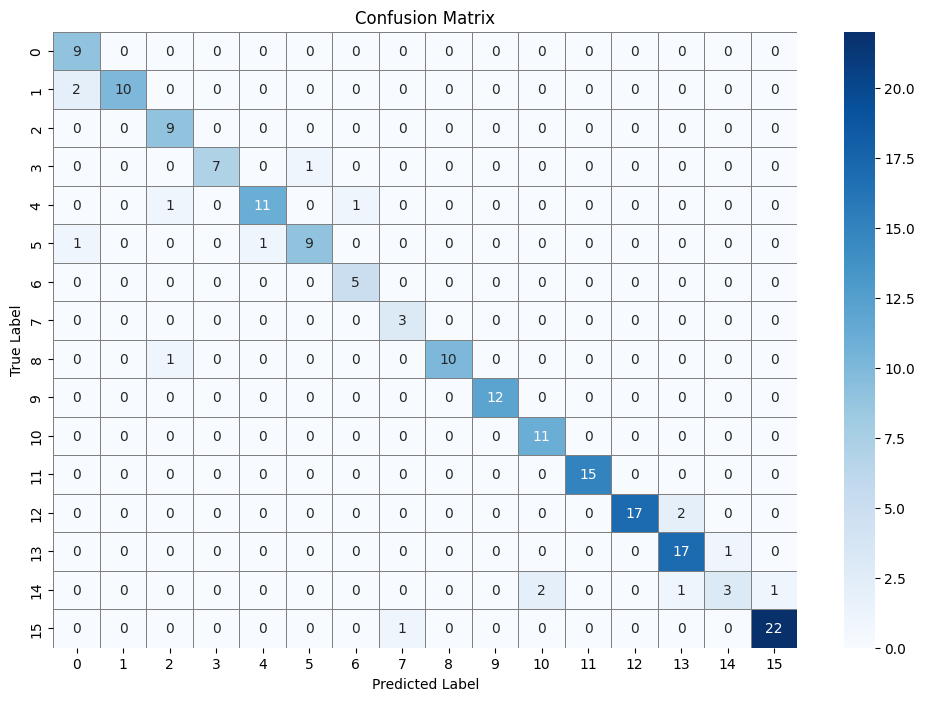

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Ambil semua label asli & prediksi
y_true = np.concatenate([y.numpy() for _, y in tf_test_dataset], axis=0)
y_pred = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in tf_test_dataset], axis=0)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi pakai heatmap dengan angka
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
